# Цель лабораторной работы
Изучить линейные модели, SVM и деревья решений<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите одну из&nbsp;линейных моделей, SVM и дерево решений. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра с&nbsp;использованием `GridSearchCV` и кросс-валидации.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются метрологические данные с&nbsp;метеостанции HI-SEAS (Hawaii Space Exploration Analog and Simulation) за&nbsp;четыре месяца (с&nbsp;сентября по&nbsp;декабрь 2016&nbsp;года)<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("./SolarPrediction.csv")

Преобразуем временные колонки в соответствующий временной формат:

In [4]:
data["Time"] = (pd
                    .to_datetime(data["UNIXTime"], unit="s", utc=True)
                    .dt.tz_convert("Pacific/Honolulu")).dt.time

data["TimeSunRise"] = (pd
                       .to_datetime(data["TimeSunRise"],
                                    infer_datetime_format=True)
                       .dt.time)

data["TimeSunSet"] = (pd
                      .to_datetime(data["TimeSunSet"],
                                   infer_datetime_format=True)
                      .dt.time)

data = data.rename({"WindDirection(Degrees)": "WindDirection"},
                   axis=1)

Проверим полученные типы:

In [5]:
data.dtypes

UNIXTime           int64
Data              object
Time              object
Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
TimeSunRise       object
TimeSunSet        object
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [6]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Очевидно, что все эти временные характеристики в&nbsp;таком виде нам не&nbsp;особо интересны. Преобразуем все нечисловые столбцы в&nbsp;числовые. В&nbsp;целом колонка `UNIXTime` нам не&nbsp;интересна, дата скорее интереснее в&nbsp;виде дня в&nbsp;году. Время измерения может быть интересно в&nbsp;двух видах: просто секунды с&nbsp;полуночи, и время, нормализованное относительно рассвета и заката. Для&nbsp;преобразования времени в&nbsp;секунды используем следующий метод<cite data-cite="so:dttseconds"></cite>:

In [7]:
def time_to_second(t):
    return ((datetime.combine(datetime.min, t) - datetime.min)
            .total_seconds())

In [8]:
df = data.copy()

timeInSeconds = df["Time"].map(time_to_second)

sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)

df = df.drop(["UNIXTime", "Data", "Time",
              "TimeSunRise", "TimeSunSet"], axis=1)

df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [9]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

С&nbsp;такими данными уже можно работать. Проверим размер набора данных:

In [10]:
df.shape

(32686, 7)

Проверим основные статистические характеристики набора данных:

In [11]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0.482959
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.602432
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,-0.634602
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,-0.040139
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0.484332
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.006038
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.566061


Проверим наличие пропусков в&nbsp;данных:

In [12]:
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [13]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]

In [14]:
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [15]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


Предобработаем данные, чтобы методы работали лучше:

In [16]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04
mean,5.565041e-16,2.904952e-14,1.391260e-17,6.956302e-17,-9.738822e-17,5.217226e-18
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.758117e+00,-4.259540e+00,-2.578560e+00,-1.724255e+00,-1.788859e+00,-1.855112e+00
25%,-8.229646e-01,-4.184734e-01,-7.316829e-01,-7.366250e-01,-8.233591e-01,-8.683240e-01
50%,-1.779139e-01,1.302504e-01,3.841386e-01,5.062367e-02,-1.787376e-01,2.279483e-03
75%,6.283995e-01,6.789742e-01,8.458578e-01,4.307058e-01,4.658840e-01,8.682924e-01
max,3.208603e+00,2.508053e+00,1.076717e+00,2.602741e+00,9.814329e+00,1.797910e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [19]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

Попробуем метод Lasso с&nbsp;гиперпараметром $\alpha=1$:

In [20]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим метрики построенной модели:

In [21]:
test_model(las_1)

mean_absolute_error: 156.39773885479397
median_absolute_error: 122.53656019076396
r2_score: 0.5959528719710016


Видно, что данный метод без&nbsp;настройки гиперпараметров несколько хуже, чем метод $K$ ближайших соседей.

### SVM

Попробуем метод NuSVR с&nbsp;гиперпараметром $\nu=0{,}5$:

In [22]:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [23]:
test_model(nusvr_05)

mean_absolute_error: 113.30399649196396
median_absolute_error: 52.28354239843286
r2_score: 0.677863113632347


Внезапно SVM показал результаты хуже по&nbsp;средней абсолютной ошибке и коэффициенте детерминации. Однако медианная абсолютная ошибка меньше, чем у&nbsp;метода Lasso.

### Дерево решений

Попробуем дерево решений с&nbsp;неограниченной глубиной дерева:

In [24]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим метрики построенной модели:

In [25]:
test_model(dt_none)

mean_absolute_error: 49.95265540871267
median_absolute_error: 0.7250000000000012
r2_score: 0.8329923378031585


Дерево решений показало прямо-таки очень хороший результат по&nbsp;сравнению с&nbsp;рассмотренными раньше методами. Оценим структуру получившегося дерева решений:

In [26]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [27]:
stat_tree(dt_none)

Всего узлов: 42969
Листовых узлов: 21485
Глубина дерева: 43
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 20.744845240865722


## Подбор гиперпараметра $K$

### Линейная модель — Lasso

Введем список настраиваемых параметров:

In [28]:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

Запустим подбор параметра:

In [29]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

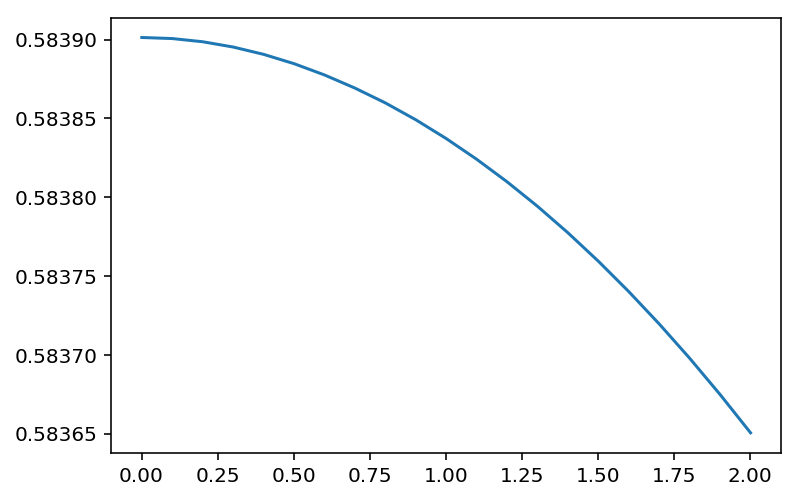

In [30]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод Lasso здесь не особо хорошо справляется, и здесь, скорее всего, было бы достаточно обычной линейной регрессии (в&nbsp;которую сходится Lasso при&nbsp;$\alpha=0$).

На&nbsp;тестовом наборе данных картина ровно та же:

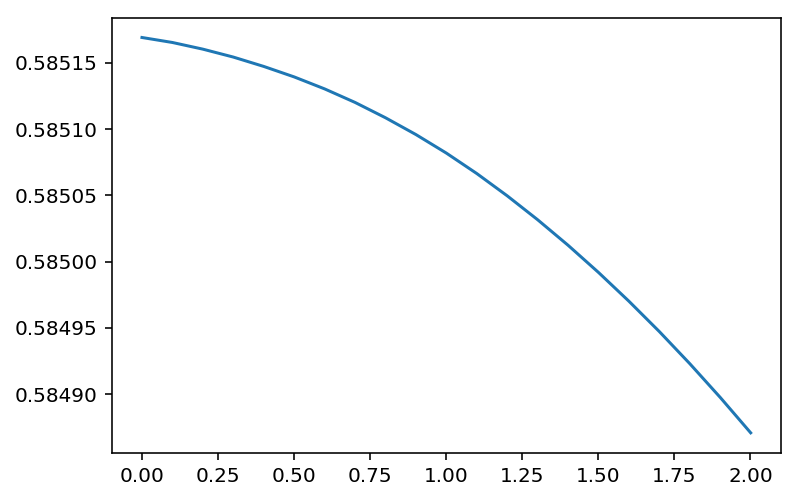

In [31]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Будем считать, что GridSearch показал, что нам нужна обычная линейная регрессия:

In [32]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 156.41472692069644
median_absolute_error: 122.73509263147955
r2_score: 0.5961416061536914


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод не&nbsp;может дать хороший результат для&nbsp;данной выборки.

### SVM

Введем список настраиваемых параметров:

In [33]:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

Запустим подбор параметра:

In [34]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

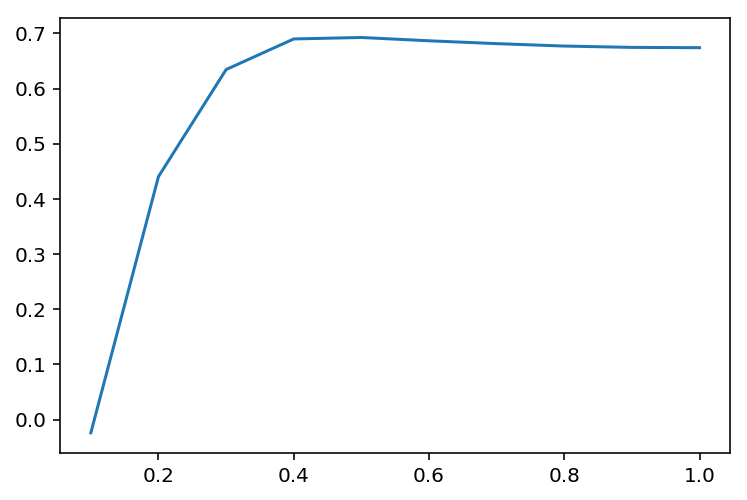

In [35]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше, но не глобально. При&nbsp;этом также видно, что разработчики библиотеки scikit-learn провели хорошую работу: получившееся оптимальное значение $\nu=0{,}5$ является стандартным для&nbsp;данного алгоритма<cite data-cite="doc:sklearn"></cite>.

На&nbsp;тестовом наборе данных картина ровно та же:

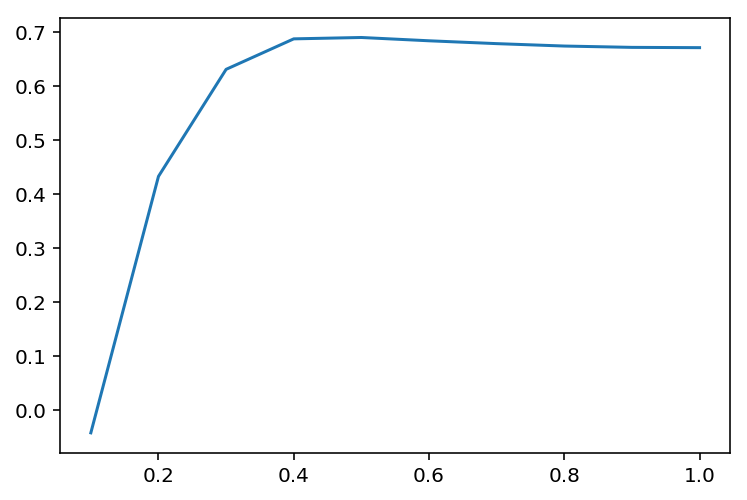

In [36]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Так как параметры подобраны те же, то и обучение модели заново производить не&nbsp;будем.

### Дерево решений

Введем список настраиваемых параметров:

In [37]:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

Запустим подбор параметра:

In [38]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

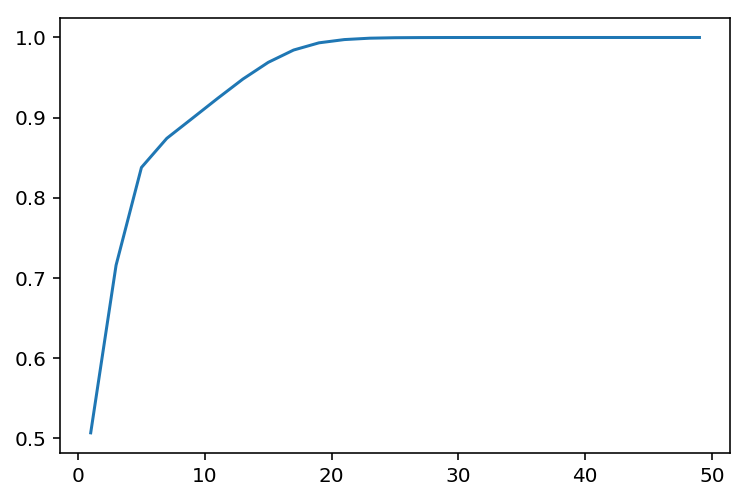

In [39]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что на&nbsp;тестовой выборке модель легко переобучается.

На&nbsp;тестовом наборе данных картина интереснее:

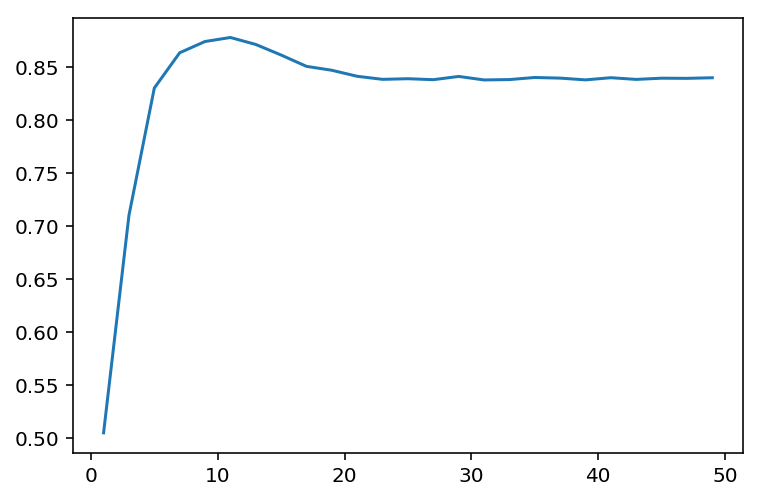

In [40]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в&nbsp;районе пика.

In [41]:
param_range = np.arange(7, 14, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 7,  8,  9, 10, 11, 12, 13])}]

In [42]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

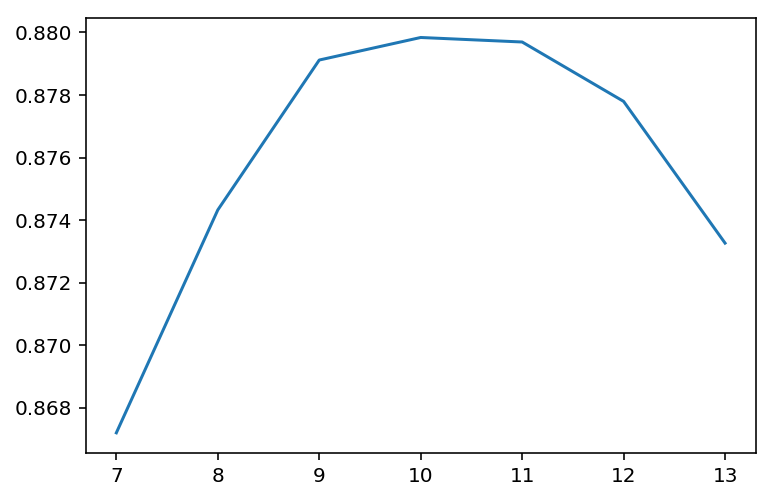

In [43]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Получили, что глубину дерева необходимо ограничить 10&nbsp;уровнями. Проверим этот результат.

In [44]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 49.37458067357269
median_absolute_error: 0.9516783975792638
r2_score: 0.8724040240942483


Вновь посмотрим статистику получившегося дерева решений.

In [45]:
stat_tree(reg)

Всего узлов: 1711
Листовых узлов: 856
Глубина дерева: 10
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 9.850467289719626


В&nbsp;целом получили примерно тот же результат. Коэффициент детерминации оказался немного выше, тогда как абсолютные ошибки также стали немного выше. Видно, что дерево решений достигло своего предела. При&nbsp;этом весьма поразительно, насколько хорошо данный метод решил задачу регрессии. Посмотрим на&nbsp;построенное дерево.

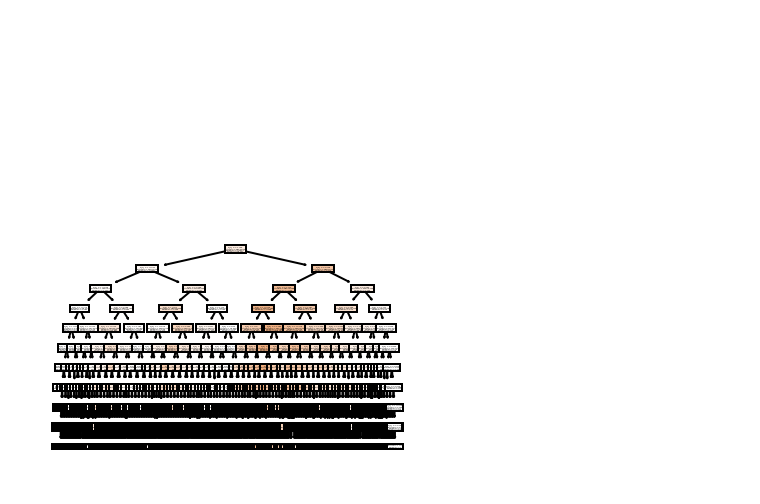

In [46]:
plot_tree(reg, filled=True);

Вывод функции `plot_tree` выглядит весьма странно. Видимо, для&nbsp;настолько больших деревьев решений она не&nbsp;предназначена. Возможно, это со&nbsp;временем будет исправлено, так как эту функциональность только недавно добавили.

In [47]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Такое дерево уже можно анализировать. Видно, что сгенерировалось огромное множество различных условий, и, фактически, модель переобучена, но с&nbsp;другой стороны дерево решений и не&nbsp;могло быть построено иначе для&nbsp;задачи регрессии. К&nbsp;тому же на&nbsp;тестовой выборке данное дерево работает также довольно хорошо, так что, возможно, оно имеет право на&nbsp;существование. Если бы стояла задача классификации, то дерево решений явно показало бы себя просто отлично.